****
# Introduction #
****
**This Notebooks goal is to Correctly classify Human Emotions based on the images present**


****
# Dataset Description and Goal #
****

**About the Dataset**


* The data consists of 48x48 pixel grayscale images of faces.
* The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.


**Goal**

* The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
* The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

****
# Loading the Directories #
****

In [1]:
# Loading the directories

train = r'C:\Users\FAST\Downloads\Ali Ahmed\Video-Feed-Detection\FER-2013\train'
test = r'C:\Users\FAST\Downloads\Ali Ahmed\Video-Feed-Detection\FER-2013\test'

****
# Reading and Preprocessing Data from Directories ##
****

In [2]:
# importing

import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


In [4]:
img_size=(48,48)
bth_size=32

# Augmenting Images for training set

trdatagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.1
)

# Only Rescaling or Normalizing the pixel values for testing Set
tedatagen = ImageDataGenerator(rescale=1.0/255)


In [5]:
# Reading the training data from directory

traingen= trdatagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale',  
    class_mode='categorical',
    shuffle=True,
    subset='training')

# Reading the testing data from Directory

testgen = tedatagen.flow_from_directory(
    test,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale', 
    class_mode='categorical',
    shuffle=False
)

# Validation data which is a subset taken from the training data (10% of the training data)
valgen = trdatagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale',  
    class_mode='categorical',
    shuffle=True,
    subset='validation'  
)

Found 25841 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 2868 images belonging to 7 classes.


****
# Displaying Training and Testing Images #
****

In [6]:
# importing
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

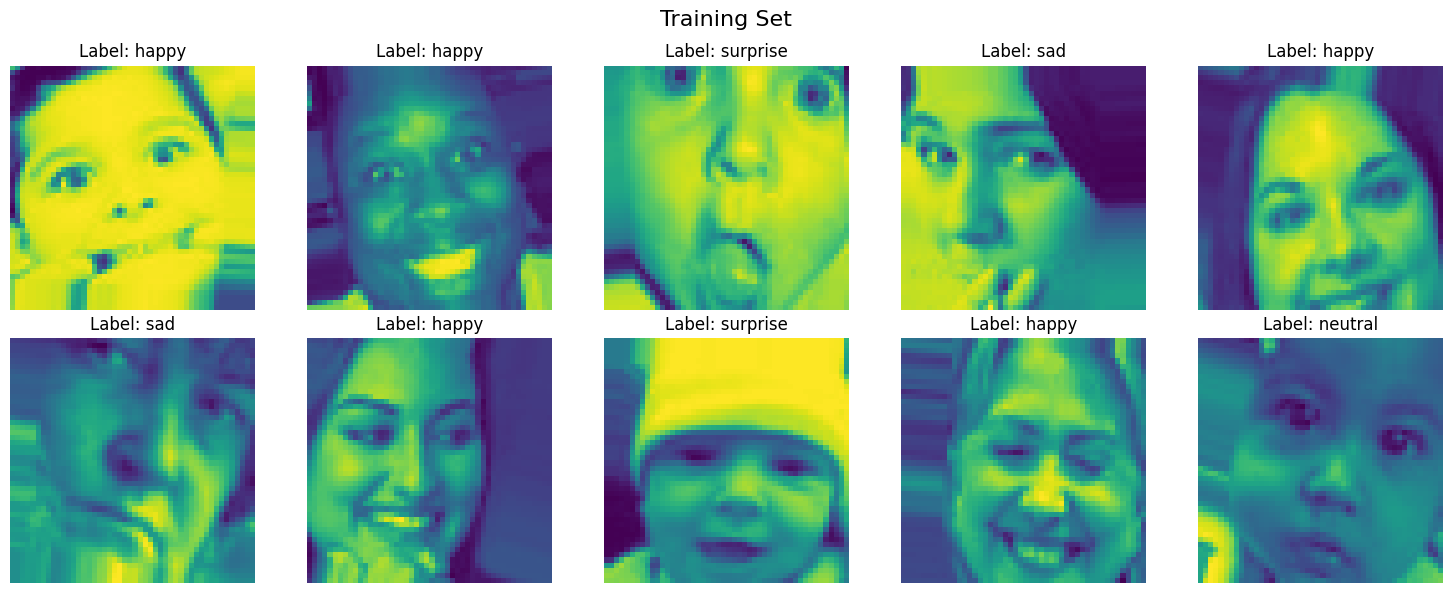

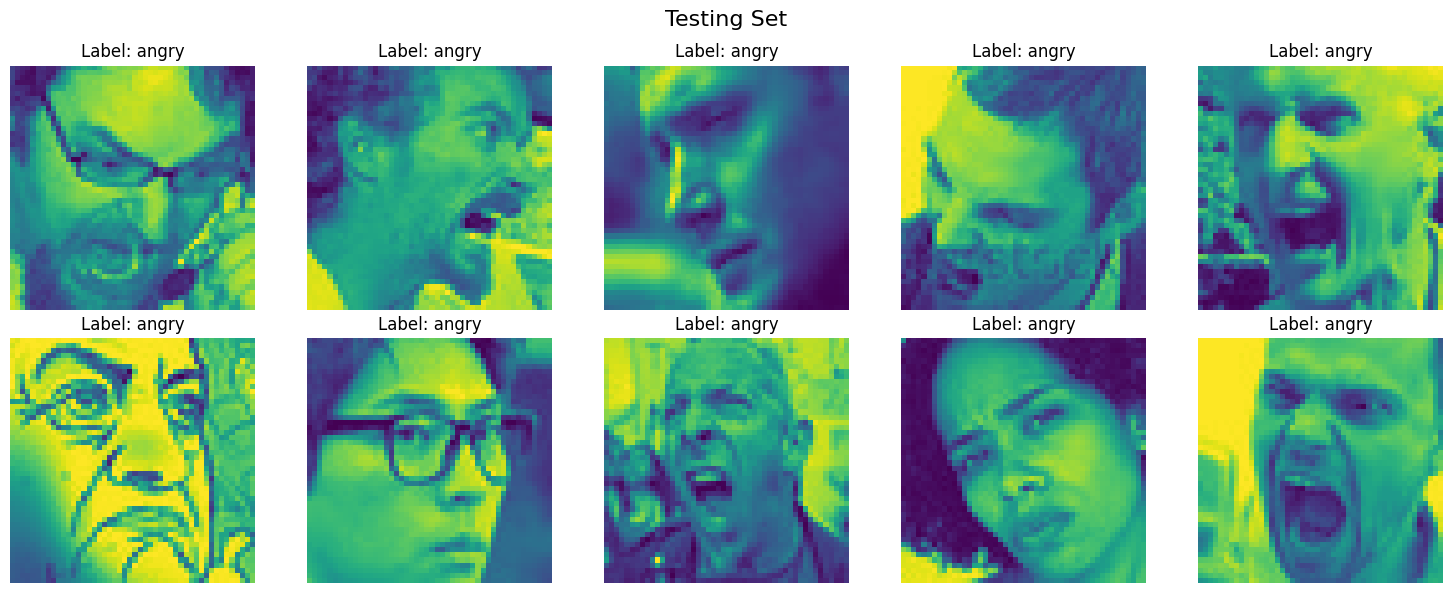

In [7]:
# Displaying the training and testing datsets
# Only 10 Images from each set

def plot_images_from_generator(generator, title, num_images=10, images_per_row=5):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for i in range(num_images):
        img = images[i]
        label = labels[i]
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {list(generator.class_indices.keys())[label.argmax()]}")
    
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_from_generator(traingen, "Training Set", num_images=10, images_per_row=5)
plot_images_from_generator(testgen, "Testing Set", num_images=10, images_per_row=5)

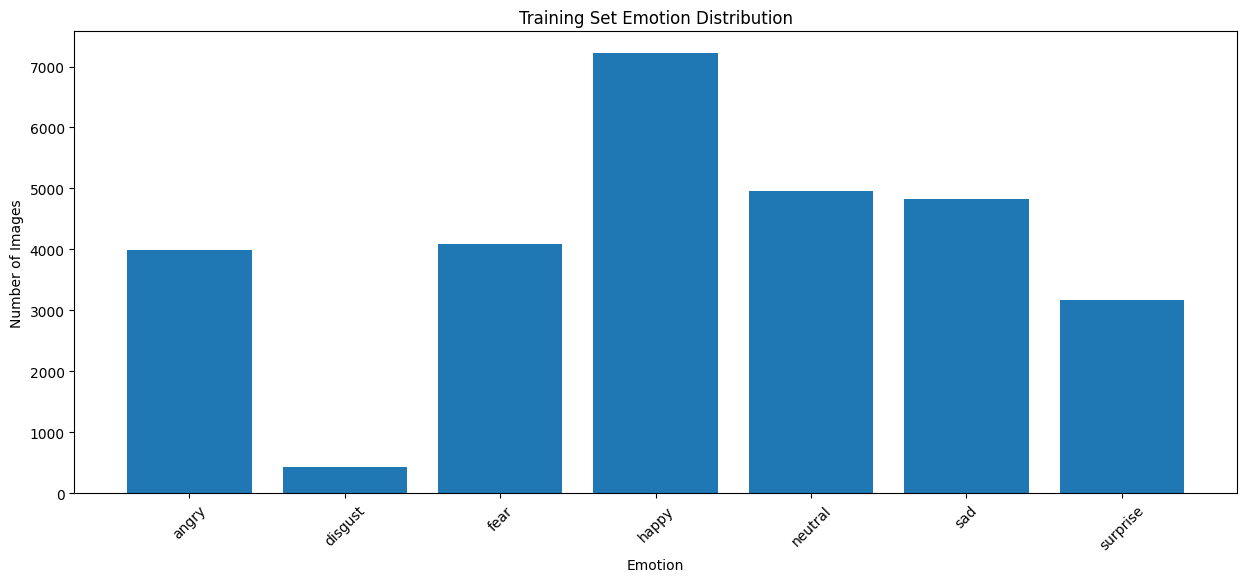

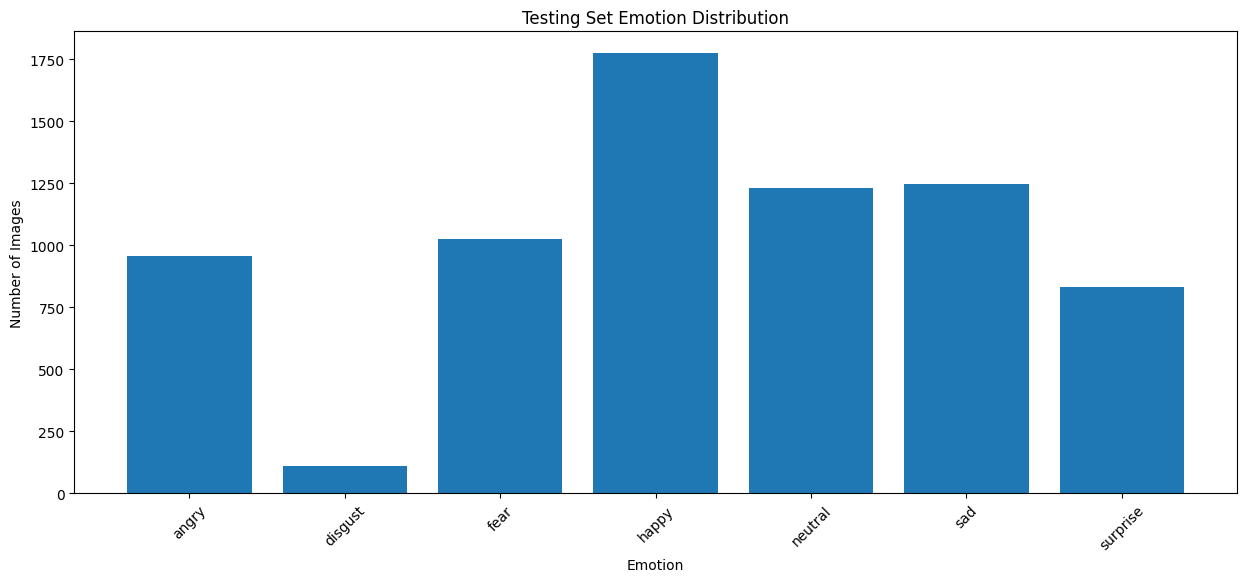

In [8]:
#class distribution

def plot_class_distribution(directory, title):
    class_names = os.listdir(directory)
    class_counts = []
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts.append(len(os.listdir(class_dir)))

    plt.figure(figsize=(15, 6))
    plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train, "Training Set Emotion Distribution")
plot_class_distribution(test, "Testing Set Emotion Distribution")

In [9]:
# Label Map
label_map = {
    0:'Angry', 
    1:'Disgust',
    2:'Fear',
    3:'Happy', 
    4:'Sad', 
    5:'Surprise', 
    6:'Neutral'
}

****
# CNN  Model #
****

In [10]:
# importing

import keras as k
from keras.models import Sequential
from keras.layers import Conv2D,BatchNormalization,Activation,GlobalAveragePooling2D,Dropout,Dense,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [11]:

model = Sequential()

# CNN Layer 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48, 48, 1)))  
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# CNN Layer 2
model.add(Conv2D(128, (5,5), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# CNN Layer 3
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#CNN Layer 4
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#CNN Layer 5
model.add(Conv2D(1024, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Global Average Pooling layer is used instead of Flatten as it is more effiecient
#Note: There is feature loss when we use GAP
model.add(GlobalAveragePooling2D())

#Dense Layer 1
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Dense Layer 2
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Dense Layer 3
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Output Layer
model.add(Dense(7, activation='softmax'))

#Adam Optimizer
opt = k.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [12]:
#Implementing Early Stopping and Learning Rate Reduction
es=EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
lr=ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, verbose=1, min_delta=0.0001)

callbacks_list=[es,lr]

In [13]:
history = model.fit(
    traingen,
    epochs=70,
    validation_data=valgen,
    callbacks=callbacks_list
)

Epoch 1/70
808/808 [==============================] - 444s 547ms/step - loss: 2.1660 - accuracy: 0.1991 - val_loss: 1.8149 - val_accuracy: 0.2402 - lr: 0.0010
Epoch 2/70
808/808 [==============================] - 592s 733ms/step - loss: 1.8370 - accuracy: 0.2374 - val_loss: 1.8017 - val_accuracy: 0.2580 - lr: 0.0010
Epoch 3/70
808/808 [==============================] - 726s 899ms/step - loss: 1.7493 - accuracy: 0.2869 - val_loss: 1.9268 - val_accuracy: 0.1967 - lr: 0.0010
Epoch 4/70
808/808 [==============================] - 845s 1s/step - loss: 1.5976 - accuracy: 0.3719 - val_loss: 1.5455 - val_accuracy: 0.3964 - lr: 0.0010
Epoch 5/70
808/808 [==============================] - 810s 1s/step - loss: 1.4768 - accuracy: 0.4308 - val_loss: 1.4980 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 6/70
808/808 [==============================] - 537s 664ms/step - loss: 1.4121 - accuracy: 0.4599 - val_loss: 1.6558 - val_accuracy: 0.3640 - lr: 0.0010
Epoch 7/70
808/808 [==============================] 

In [14]:
#Predicting
test_loss, test_accuracy = model.evaluate(testgen)

225/225 [==============================] - 44s 197ms/step - loss: 0.9771 - accuracy: 0.6344


In [16]:
# Saving the trained model
model.save('emotion_detection_model.h5')
model.save('emotion_detection_model.keras')


****
# Evaluation Metrics #
****

In [17]:
# importing
from sklearn.metrics import classification_report, confusion_matrix

Test Accuracy: 0.63
225/225 [==============================] - 19s 82ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.62      0.56       958
           1       0.57      0.36      0.44       111
           2       0.58      0.28      0.37      1024
           3       0.87      0.84      0.86      1774
           4       0.50      0.75      0.60      1233
           5       0.55      0.45      0.49      1247
           6       0.74      0.79      0.76       831

    accuracy                           0.63      7178
   macro avg       0.62      0.58      0.58      7178
weighted avg       0.64      0.63      0.62      7178

Confusion Matrix:
[[ 590   13   36   29  179   82   29]
 [  50   40    3    1    6    8    3]
 [ 176    7  284   25  197  208  127]
 [  58    1   23 1495  128   34   35]
 [  63    4   25   68  930  124   19]
 [ 166    4   61   65  370  561   20]
 [  37    1   60   32   39    8  654]] 




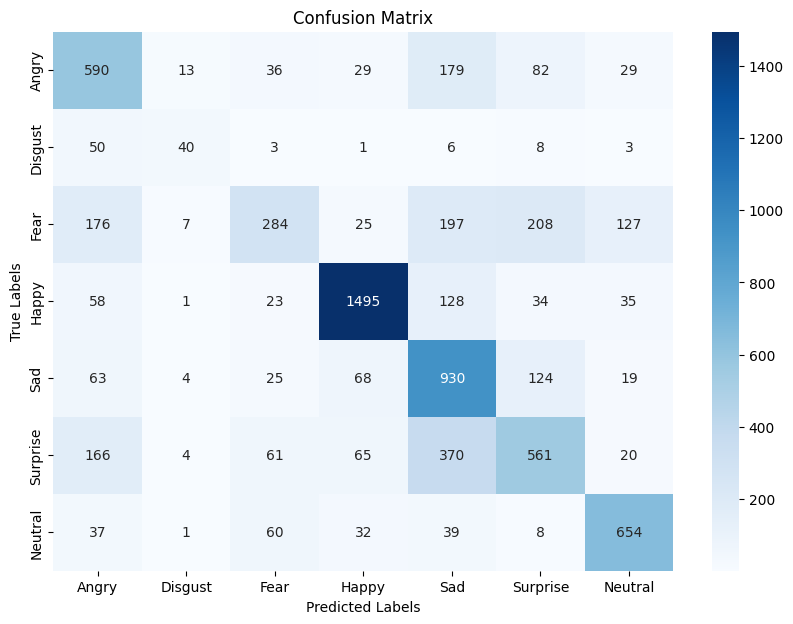

Training class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [18]:
print(f"Test Accuracy: {test_accuracy:.2f}")
y_pred = np.argmax(model.predict(testgen), axis=1)
y_true = testgen.classes
print("Classification Report:")
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix,'\n\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_map.values()), 
            yticklabels=list(label_map.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print("Training class indices:", traingen.class_indices)
print("Test class indices:", testgen.class_indices)


In [3]:
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert true labels to one-hot encoding for ROC calculations
y_true_onehot = label_binarize(y_true, classes=[0, 1, 2, 3, 4,5,6])
y_pred_prob = model.predict(testgen)

plt.figure(figsize=(10, 7))

# Plot ROC for each class
for i, class_name in label_map.items():
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

NameError: name 'y_true' is not defined

****
# Feedback and Suggestions #
****

**Add python file**
